# Análisis del problema

El objetivo de este proyecto es desarrollar un modelo de aprendizaje profundo capaz de convertir voz en texto.  
Para ello, se analizará un conjunto de datos de audio y se entrenará un modelo utilizando TensorFlow.  
Los desafíos incluyen el manejo de diferentes acentos, entonaciones y ruido en los datos de entrada.


In [ ]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 52.3 MB/s eta 0:00:00


# Carga de datos

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import Callback,ModelCheckpoint
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer
import random
import time

In [ ]:
import tensorflow as tf
print(tf.__version__)

print("GPU Available:", tf.test.is_gpu_available())

if tf.test.is_gpu_available():
    device_name = tf.test.gpu_device_name()

else:
    device_name = 'cpu:0'

print(device_name)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2.17.1
GPU Available: True
/device:GPU:0


In [ ]:
!tar -xvzf data.gz -C ./sample_data

Streaming output truncated to the last 5000 lines.
cv-corpus-17.0-delta-2024-03-15/es/clips/common_voice_es_39848025.mp3
cv-corpus-17.0-delta-2024-03-15/es/clips/common_voice_es_39848428.mp3
cv-corpus-17.0-delta-2024-03-15/es/clips/common_voice_es_39848429.mp3
cv-corpus-17.0-delta-2024-03-15/es/clips/common_voice_es_39848430.mp3
cv-corpus-17.0-delta-2024-03-15/es/clips/common_voice_es_39848431.mp3
cv-corpus-17.0-delta-2024-03-15/es/clips/common_voice_es_39848432.mp3
cv-corpus-17.0-delta-2024-03-15/es/clips/common_voice_es_39850417.mp3
cv-corpus-17.0-delta-2024-03-15/es/clips/common_voice_es_39850418.mp3
cv-corpus-17.0-delta-2024-03-15/es/clips/common_voice_es_39850419.mp3
cv-corpus-17.0-delta-2024-03-15/es/clips/common_voice_es_39850420.mp3
cv-corpus-17.0-delta-2024-03-15/es/clips/common_voice_es_39850421.mp3
cv-corpus-17.0-delta-2024-03-15/es/clips/common_voice_es_39855870.mp3
cv-corpus-17.0-delta-2024-03-15/es/clips/common_voice_es_39855871.mp3
cv-corpus-17.0-delta-2024-03-15/es/clip

# Preparación de los datos

In [ ]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnñopqrstuvwxyzáéíóúü'?! "]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

NameError: name 'keras' is not defined

In [ ]:
DATASET_PATH = "/content/sample_data/cv-corpus-17.0-delta-2024-03-15/es"
wavs_path = DATASET_PATH + "/clips/"
metadata_path = DATASET_PATH + "/validated.tsv"

# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="\t")[["path", "sentence"]]
metadata_df = metadata_df.rename(columns={"path": "audio"})
print("Metadata shape: ", metadata_df.shape)
metadata_df.head(5)

Metadata shape:  (62, 2)


,audio,sentence
0,common_voice_es_39758765.mp3,Disfrute la premiada película sobre las caract...
1,common_voice_es_39611830.mp3,Se descubrió que el capitán y los controladore...
2,common_voice_es_39740283.mp3,"Y hecho este estruendo, juntóse la multitud;"
3,common_voice_es_39802233.mp3,El escudo de armas-es de los tiempos modernos.
4,common_voice_es_39765377.mp3,Desde entonces se cree que fue arrojado al mar.


In [ ]:

# Split the dataframe into training and validation sets
train_df = metadata_df.sample(frac=0.8, random_state=42)
valid_df = metadata_df.drop(train_df.index)

print(f"Size of training set: {len(train_df)}")
print(f"Size of validation set: {len(valid_df)}")

Size of training set: 50
Size of validation set: 12


In [ ]:
!pip install tensorflow_io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 23.5 MB/s eta 0:00:00


In [ ]:
# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384
import tensorflow_io as tfio

def encode_single_sample(mp3_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read MP3 file
    file = tf.io.read_file(wavs_path + mp3_file)
    # 2. Decode the MP3 file
    audio = tfio.audio.decode_mp3(file)
    audio = tf.squeeze(audio, axis=-1)  # Ensure it's 1D
    # 3. Change type to float and normalize
    audio = tf.cast(audio, tf.float32) / 32768.0  # Normalize from int16 range to float [-1, 1]
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. Normalization
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)

    ###########################################
    ##  Process the Label
    ##########################################
    # 7. Convert label to lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)

    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

In [ ]:
batch_size =8# 32
# Define the trainig dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(train_df["audio"]), list(train_df["sentence"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(valid_df["audio"]), list(valid_df["sentence"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 193), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

# Visualización




In [ ]:
for audio, sentence in train_dataset.take(1):
    print("Espectograma //",audio)
    print("Texto de aprendizaje // ",tf.strings.reduce_join(num_to_char(sentence[0])).numpy().decode("utf-8"))
    print("Texto Real // ",train_df["sentence"].tolist()[0])

Espectograma // tf.Tensor(
[[[ 1.0284699   0.82545537  0.42004728 ... -1.2779955  -1.2560052
   -1.2478417 ]
  [ 1.1463307   0.9702974   0.82796973 ... -1.288048   -1.2874057
   -1.287961  ]
  [-0.4448272   0.16316193  0.6818994  ... -1.2567334  -1.2546822
   -1.2521992 ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 2.5439193   2.2973733   1.6709459  ... -1.0219349  -1.020148
   -1.0237553 ]
  [ 2.4786012   2.1761043   1.452015   ... -1.0462067  -1.0529007
   -1.0486522 ]
  [-0.09393692  0.2269176   1.1721966  ... -1.0191034  -1.0208086
   -1.0242598 ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.          

Frecuencia de muestreo del MP3: 32000 Hz
Raw Audio Shape: (141696, 1), Dtype: float32, Min: -0.5326491594314575, Max: 0.5055412650108337
Normalized Audio Shape: (141696,), Min: -1.0, Max: 0.9491074085235596


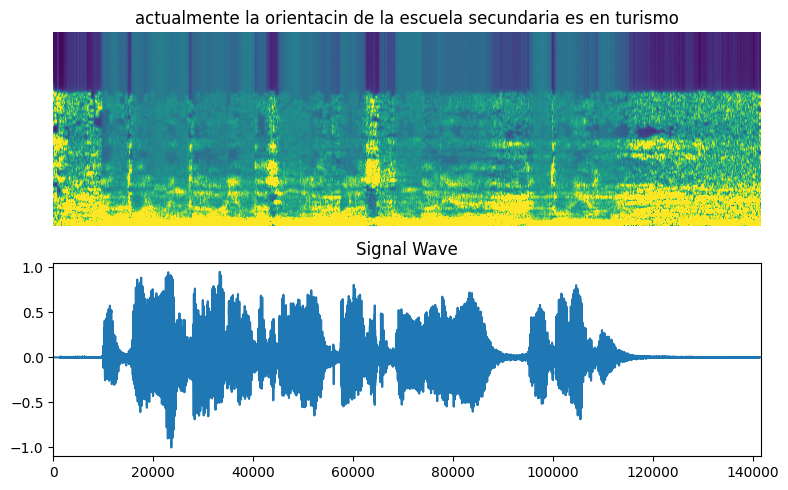

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
from IPython import display

fig = plt.figure(figsize=(8, 5))

for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]

    # Decode the label
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")

    # Plot the Spectrogram
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1, aspect="auto", origin="lower")
    ax.set_title(label)
    ax.axis("off")

    # Read and decode the MP3 file
    file = tf.io.read_file(wavs_path + list(train_df["audio"])[0])

    myAudio = tfio.audio.AudioIOTensor(wavs_path + list(train_df["audio"])[1])

    # Obtener la frecuencia de muestreo original
    original_rate = myAudio.rate.numpy()
    print(f"Frecuencia de muestreo del MP3: {original_rate} Hz")
    audio = tfio.audio.decode_mp3(file).numpy()

    # Debugging: Inspect raw audio
    print(f"Raw Audio Shape: {audio.shape}, Dtype: {audio.dtype}, Min: {audio.min()}, Max: {audio.max()}")

    # Reshape and normalize the audio
    audio = np.squeeze(audio)  # Flatten to 1D array
    audio = audio / np.max(np.abs(audio))  # Normalize to [-1.0, 1.0]
    audio = np.clip(audio, -1.0, 1.0)  # Ensure values are within the range

    # Debugging: Verify normalization
    print(f"Normalized Audio Shape: {audio.shape}, Min: {audio.min()}, Max: {audio.max()}")

    # Plot the audio waveform
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))

    # Display the audio for playback
    try:
        display.display(display.Audio(audio, rate=32000 ))  # Set the correct sampling rate
    except Exception as e:
        print(f"Error in display.Audio: {e}")

plt.tight_layout()
plt.show()


# Modelo de Deep Learning

In [ ]:

def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss


In [ ]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    from tensorflow.keras import layers, models, optimizers
    from tensorflow.keras.backend import ctc_batch_cost as CTCLoss

    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]), name="reshape_to_rnn")(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5, name=f"dropout_{i}")(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_activation")(x)  # Renamed to ensure uniqueness
    x = layers.Dropout(rate=0.5, name="dropout_final")(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax", name="output")(x)
    # Model
    model = models.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = optimizers.Adam(learning_rate=0.0001)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Correct fft_length based on the error message
correct_fft_length = 2 * (193 - 1)

# Rebuild the model with the corrected input dimension
model = build_model(
    input_dim=193,
    output_dim=num_to_char.vocabulary_size(),
    rnn_units=512
)
model.summary(line_length=110)

Model: "DeepSpeech_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                             │ (None, None, 193)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ expand_dim (Reshape)                           │ (None, None, 193, 1)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1 (Conv2D)                                │ (None, None, 97, 32)                │              14,432 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_bn (BatchNormalization)                 │ (None, None, 97, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_relu (ReLU)                             │ (None, None, 97, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2 (Conv2D)                                │ (None, None, 49, 32)                │             236,544 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_bn (BatchNormalization)                 │ (None, None, 49, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_relu (ReLU)                             │ (None, None, 49, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ reshape_to_rnn (Reshape)                       │ (None, None, 1568)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_1 (Bidirectional)                │ (None, None, 1024)                  │           6,395,904 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_1 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_2 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_2 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_3 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_3 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_4 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_4 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├───

 Total params: 26,628,480 (101.58 MB)

 Trainable params: 26,628,352 (101.58 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    #plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('loss_curve.png')
    #plt.show()

Epoch 1/20


Exception ignored in: <function Wave_write.__del__ at 0x7cc8e53c7490>
Traceback (most recent call last):
  File "/usr/lib/python3.10/wave.py", line 326, in __del__
    self.close()
  File "/usr/lib/python3.10/wave.py", line 444, in close
    self._ensure_header_written(0)
  File "/usr/lib/python3.10/wave.py", line 467, in _ensure_header_written
    self._write_header(datasize)
  File "/usr/lib/python3.10/wave.py", line 471, in _write_header
    self._file.write(b'RIFF')
ValueError: I/O operation on closed file.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : esta especie se caracteriza por el vientre oscuro con pequeas manchas blancas
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : adems los dos equipos con menor puntaje descendieron a la segunda divisin
Prediction: 
----------------------------------------------------------------------------------------------------
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - loss: 1130.9884 - val_loss: 462.5936
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
--

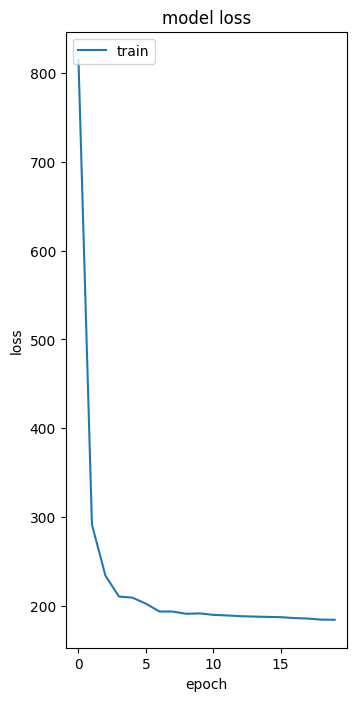

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)#1e-4)
model.compile(optimizer=opt, loss=CTCLoss)
# Define the number of epochs.
epochs = 20
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback, MetricsCheckpoint('logs')],
    verbose=1
)

plot_learning_curve(history)
plt.show()

# Evaluación

In [ ]:
# Let's check results on more validation samples
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : tiene fachada cuadrada dividida en dos pisos
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : le sobreviven su esposa hija y cuatro hijos
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : adems los dos equipos con menor puntaje descendieron a la segunda divisin
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : l puede jugar en varias posiciones defensivas pero es un lateral derecho natural
Prediction: 
-------------------------------------------------

# Conclusión


**Conclusión:**  
El desarrollo de un modelo de aprendizaje profundo para convertir voz a texto es una tarea desafiante que implica manejar variaciones en acentos, ruido ambiental y calidad del audio. Este tipo de proyectos tiene aplicaciones significativas en accesibilidad, asistentes virtuales y automatización. Los resultados de modelos iniciales suelen demostrar la capacidad de capturar patrones en los datos, pero su rendimiento puede mejorarse mediante el ajuste de hiperparámetros, el aumento del conjunto de datos y la implementación de arquitecturas avanzadas como redes neuronales recurrentes o transformadores. Este proyecto sienta las bases para aplicaciones más robustas y precisas en el futuro.
